In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from warmup_scheduler import GradualWarmupScheduler 

from torch.utils.tensorboard import SummaryWriter
import shutil
import cv2

plt.style.use('seaborn')
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# import data_loaders as dl

# import helpers 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



NUM_EPOCHS = 24
LR = 0.001

device

device(type='cuda')

# Assignment 4

#### **Task 1**
 - Implement a Convolutional LSTM (ConvLSTM() and/or ConvLSTMCell()) from scratch

<center><img style="width: 40%" src="imgs/conv-lstm.png"></center>
<!-- image taken from  https://www.jie-tao.com/convolutional-lstm/ -->

In [2]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTMCellClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, bias=True):
        super(ConvLSTMCellClassifier, self).__init__()

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.bias = bias

        self.classifier = nn.Linear(81920, 6)

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor):
        
        b, _, _, h, w = input_tensor.size()


        # if hidden_state is not None:
        #     raise NotImplementedError()
        # else:
        #     # Since the init is done in forward. Can send image size here
        hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []


        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)

        layer_output_list = layer_output_list[-1:]

        result = layer_output_list[0]
        result = result[:, -1, :, :, :]
        result = torch.flatten(result, 1, -1)
        result = self.classifier(result)
        return result

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

## Task 2
here is my (Siarhei's) implementation of Task2.1 <br>
File **assignment04_task2.ipynb** contains version of Wasim and all the subtasks of Task 2 up to training of ConvLSTM (excluding). <br>
Training of ConvLSTM and 3D-CNN are in the current file

Let's download and unzip 

In [3]:
import requests
import os
from datetime import datetime
from zipfile import ZipFile

relative_data_path = "./data/KTH/"
logfile_path = "log.txt"
sequence_file_path = "sequences.txt"
log_file_lines = []
if not os.path.exists(relative_data_path):
    # if the data directory is not present 
    # then create it.
    os.makedirs(relative_data_path)
if not os.path.exists(relative_data_path + logfile_path):
    # if the logfile is not present 
    # then create it.
    log_file = open(relative_data_path + logfile_path, 'w')
    dt = datetime.now()
    log_file.writelines(str(dt) + " _ " + "Logfile created \n" )
    log_file.close()
else:
    # read the logfile and check if the file is already downloaded
    log_file = open(relative_data_path + logfile_path, 'r')
    log_file_lines = log_file.readlines()
    log_file.close()
    log_file_lines = [line.strip() for line in log_file_lines]
    timestamp = log_file_lines[0].split("_")[0].strip()
    log_file_lines = [line.split(".")[0] for line in log_file_lines[1:]]




actions_arr = ["boxing", "handclapping", "handwaving", "jogging", "running", "walking"]
url_base = "http://www.csc.kth.se/cvap/actions/"
sequence_file_url = url_base + "00" + sequence_file_path
r=requests.get(sequence_file_url)
open(relative_data_path + sequence_file_path, 'wb').write(r.content)

for action in actions_arr:
    if action in log_file_lines:
        print("File already downloaded: ", action, ".zip")
        continue
    url = url_base + action + ".zip"
    r = requests.get(url, allow_redirects=True)
    open(relative_data_path + action + ".zip", 'wb').write(r.content)
    if os.path.exists(relative_data_path + logfile_path):
        log_file = open(relative_data_path + logfile_path, 'a')
        log_file.writelines(action + ".zip\n" )
        log_file.close()

if not os.path.exists(relative_data_path + "videos"):
    print("Extracting videos: ",end="")
    os.makedirs(relative_data_path + "videos")
    for action in actions_arr:
        print(action, end=", ")
        with ZipFile(relative_data_path + action + ".zip", 'r') as zipObj:
            zipObj.extractall(relative_data_path + "videos")
else:
    print("Videos are already extracted")

# if something goes wrong, delete the data directory and try again

File already downloaded:  boxing .zip
File already downloaded:  handclapping .zip
File already downloaded:  handwaving .zip
File already downloaded:  jogging .zip
File already downloaded:  running .zip
File already downloaded:  walking .zip
Videos are already extracted


Let's prepare data for learning. The following code is heavily inspired by this file: https://github.com/tejaskhot/KTH-Dataset/blob/master/prepare_data.py

In [4]:
import subprocess
import shutil
import pathlib
import time

proj_dir = os.getcwd()
video_files=os.listdir(relative_data_path + 'videos/')
video_files.sort()

abs_path = str(pathlib.Path().parent.absolute()).replace("\\", "/") 

def filterNone(x):
    	return x != ''

if(os.path.exists(relative_data_path + 'data/frames/')):
	print("Frames are already extracted")
else:
	# extract frames from video clips
	args=['ffmpeg', '-i']
	for i, video in enumerate(video_files):
		# print video
		video_name = video[:-11]	# remove '_uncomp.avi' from name
		# print('video name is: ', video_name)
		frame_name = 'frame_%d.jpg'	# count starts from 1 by default
		os.makedirs(relative_data_path + 'data/frames/'+video_name)
		args.append(abs_path + relative_data_path[1:] +'videos/'+video)
		args.append(abs_path + relative_data_path[1:] + 'data/frames/'+video_name+'/'+frame_name)

		ffmpeg_call = ' '.join(args)
		# subprocess.call(ffmpeg_call, shell=True)		# execute the system call to ffmpeg                 <-- does not work in windows 
		#                                      https://stackoverflow.com/questions/22769108/running-ffmpeg-command-through-python-script
		#ffmpeg installation path
		appDir=r"c:\ffmpeg\bin"
		os.chdir(appDir)
		os.system(ffmpeg_call)
		os.chdir(proj_dir)
		
		args=['ffmpeg', '-i']
		if (video_files.index(video) + 1) % 50 == 0:
			print('Completed till video : ', (video_files.index(video) + 1))
			

	print('[MESSAGE]	Frames extracted from all videos')

	os.makedirs(relative_data_path + 'data/' + 'TRAIN')
	os.makedirs(relative_data_path + 'data/' + 'VALIDATION')
	os.makedirs(relative_data_path + 'data/' + 'TEST')

	train = [11, 12, 13, 14, 15, 16, 17, 18]
	validation =[19, 20, 21, 23, 24, 25, 1, 4]
	test = [22, 2, 3, 5, 6, 7, 8, 9, 10]

	os.chdir(proj_dir)
	# read file line by line and strip new lines
	lines = [line.rstrip('\n').rstrip('\r') for line in open(relative_data_path + 'sequences.txt')]
	lines = lines[22:]
	# remove blank entries i.e. empty lines
	
	lines = list(filter(filterNone, lines))

	# split by tabs and remove blank entries
	lines = [line.split('\t') for line in lines]

	lines.sort()

Frames are already extracted


In [5]:
def read_crop_resize(img_path, dsize = (64, 64)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img[:, 15:145]
    img = cv2.resize(img, dsize)
    return img

def read_gray(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return img

In [6]:
success_count=0
error_count=0
if(len(os.listdir(relative_data_path + 'data/TEST/'))==0):

	for line in lines:
		vid = line[0].strip(' ')
		print(vid)
		subsequences = line[-1].split(',')
	
		person = int(vid[6:8])
		if person in train:
			move_to = 'TRAIN'
		elif person in validation:
			move_to = 'VALIDATION'
		else:
			move_to = 'TEST'
		for seq in subsequences:
			try:
				limits=seq.strip(' ').split('-')
				seq_path=relative_data_path + 'data/' + move_to + '/' + vid + '_frame_' + limits[0] + '_' + limits[1]
				os.makedirs(seq_path)
			except:
				print('-----------------------------------------------------------')
				print('[ERROR MESSAGE]: ')
				print('limits : ', limits)
				print('seq_path : ', seq_path)
				print('-----------------------------------------------------------')
				continue
			error_flag=False
			for i in range(int(limits[0]), int(limits[1])):
				src = relative_data_path + 'data' + '/frames/' + vid + '/frame_' + str(i) + '.jpg'
				# print i, src, limits
				dst = seq_path
				try:
					# shutil.copy(src, dst)
					img = read_gray(src)
					cv2.imwrite(dst + '/frame_' + str(i) + '.jpg', img)
				
				except:
					error_flag = True
			if error_flag:
				print("[ERROR]: ", seq_path)
				error_count+=1

		if (lines.index(line) + 1) % 50 == 0:
			print('Completed till video : ', (lines.index(line) + 1))
		success_count+=1

	print('[ALERT]		Total error count is : ', error_count)
	print('[MESSAGE]	Data split into train, validation and test')

else:
	print("Frames are already split into train, validation and test")

Frames are already split into train, validation and test


Let's create Custom Dataset class for our data

In [7]:
import glob

# KTH_Dataset class is inspired by the following link: https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d

class KTH_Dataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None) -> None:
        self.path = dir
        self.transform = transform
        samples_list = glob.glob((self.path + '/*'))
        # print(samples_list)
        self.data = []
        for sample_path in samples_list:
            class_name = sample_path.split('_')[1]
            # print(sample_path)
            frames_path_list = glob.glob(sample_path + '/*.jpg')
            size = len(frames_path_list)
            num_of_20_frame_sequences = size // 20
            for i in range(num_of_20_frame_sequences):
                sequence_list = []
                sequence_list = frames_path_list[i*20 : (i+1)*20]
                self.data.append((sequence_list, class_name))
                
                
        self.class_map = {'boxing': 0, 'handclapping': 1, 'handwaving': 2, 'jogging': 3, 'running': 4, 'walking': 5}
        self.class_map_inv = {0: 'boxing', 1: 'handclapping', 2: 'handwaving', 3: 'jogging', 4: 'running', 5: 'walking'}
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        imgs_path_list, class_name = self.data[index]
        imgs = []
        for img_path in imgs_path_list:
            try:
                img = read_crop_resize(img_path)
            except:
                img = np.zeros((64, 64))
            imgs.append(img)
        imgs = np.array(imgs)
        class_label = self.class_map[class_name]
        if(self.transform):
            img_tensor = self.transform(imgs).reshape(20, 1, 64, 64)
        else:
            img_tensor = torch.from_numpy(imgs.astype(np.float32))
            img_tensor = img_tensor.reshape(20, 1, 64, 64)
        class_tensor = torch.tensor(class_label)
        return img_tensor, class_tensor



transform = transforms.Compose([
                                transforms.ToTensor()
                                ])
test_ds = KTH_Dataset(relative_data_path + 'data/TEST')
train_ds = KTH_Dataset(relative_data_path + 'data/TRAIN')
val_ds = KTH_Dataset(relative_data_path + 'data/VALIDATION')

In [8]:
train_ds.__getitem__(0)[0].shape

torch.Size([20, 1, 64, 64])

In [9]:
train_ds.__len__()

3350

Let's check a sample sequence from dataset

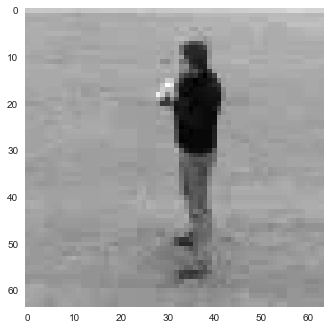

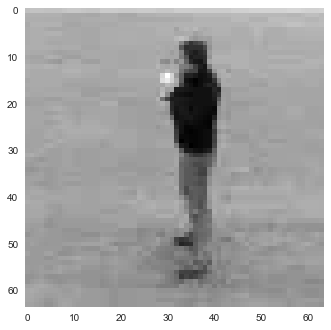

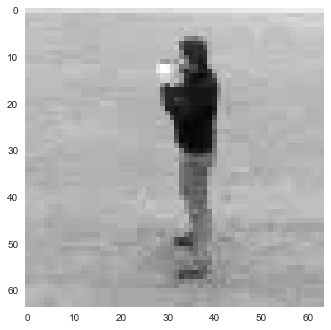

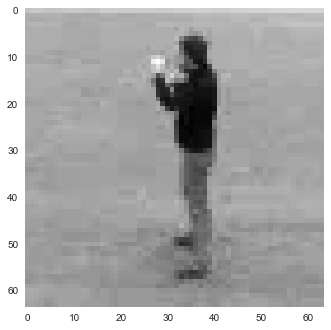

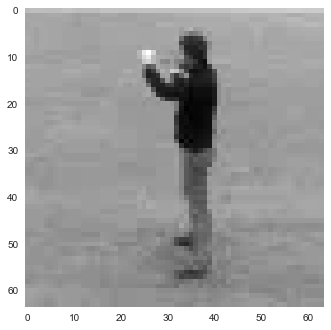

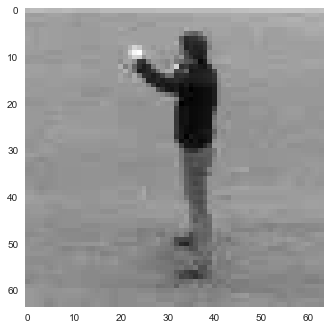

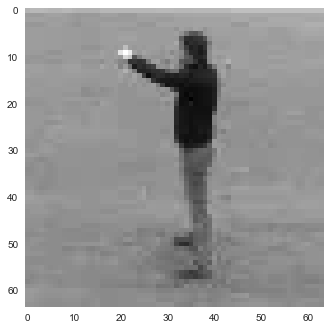

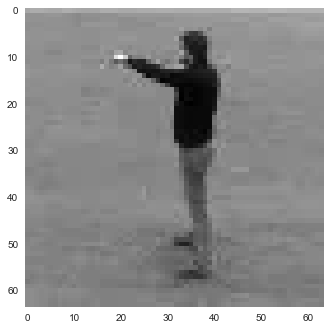

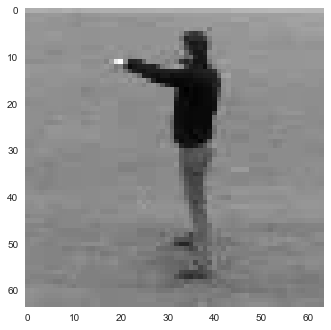

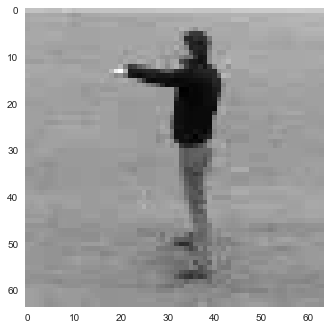

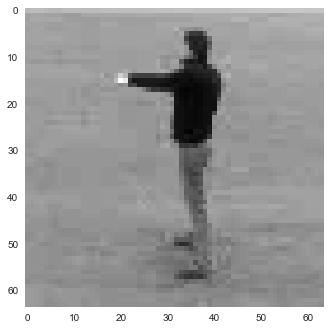

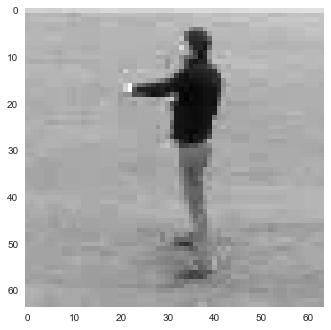

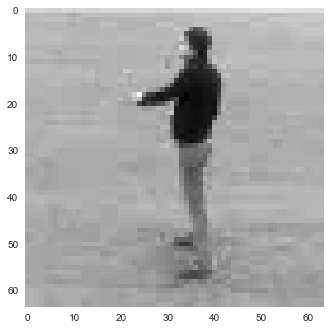

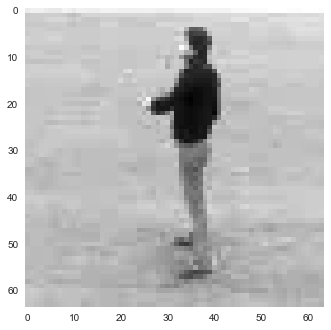

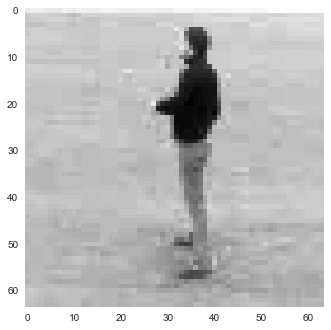

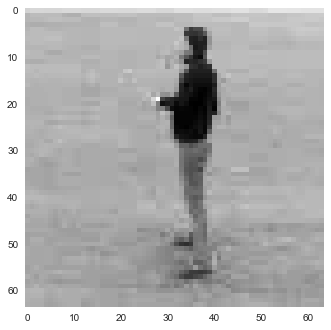

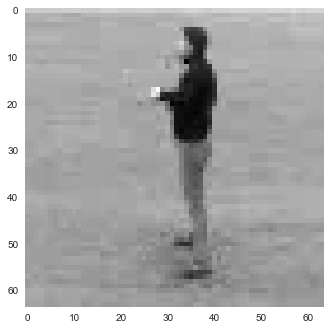

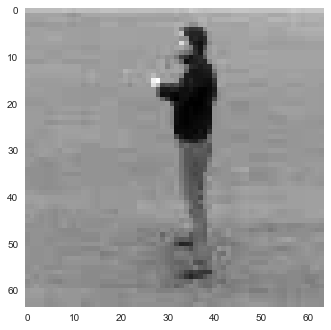

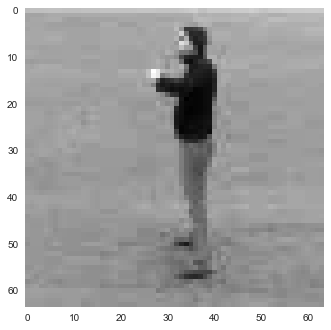

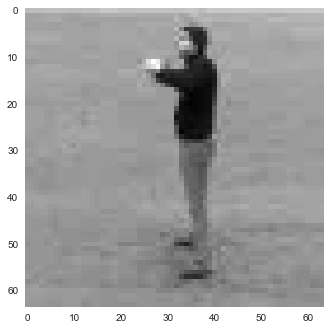

In [10]:
# show the first 20 frames of the first sequence of the first video
for i in range(20):
    plt.imshow(test_ds.__getitem__(0)[0][i][0], cmap='gray')
    plt.show()

#### Dataloader

In [11]:
# concatenate traininig and validation dataset
train_val_ds = torch.utils.data.ConcatDataset([train_ds, val_ds])
train_val_ds.__len__()

6582

In [12]:
test_ds.__len__()

3521

In [13]:
BATCH_SIZE = 64


train_loader = torch.utils.data.DataLoader(dataset=train_val_ds, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           #collate_fn=collator,
                                           #num_workers=4,
                                           drop_last=True
                                           ) 

test_loader =  torch.utils.data.DataLoader(dataset=test_ds,
                                            batch_size=BATCH_SIZE,
                                            #num_workers=4,
                                            shuffle=False)

In [14]:
# get some random training images
for i, batch_sample in enumerate(test_loader):
    print(batch_sample[0].shape)
    print(batch_sample[1].shape)
    break
    
#images, labels = dataiter.next()


torch.Size([64, 20, 1, 64, 64])
torch.Size([64])


In [15]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)

                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [16]:
def plot_analysis(loss_iters, train_loss, val_loss, valid_acc, title):
    """
    flag: plot accuracy only
    """
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)
    fig.suptitle(title)
    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_title("Training Progress")

    epochs = np.arange(len(train_loss)) + 1
    ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
    ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_title("Loss Curves")
    
    epochs = np.arange(len(val_loss)) + 1
    ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Accuracy (%)")
    ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

    plt.show()

In [17]:
conv_lstm = ConvLSTMCellClassifier(input_dim=1, hidden_dim=[20], kernel_size=(3, 3), num_layers=1, bias=True)
conv_lstm = conv_lstm.to(device)

# classification loss function
criterion_conv_lstm = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_conv_lstm = torch.optim.Adam(conv_lstm.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler_conv_lstm = torch.optim.lr_scheduler.StepLR(optimizer_conv_lstm, step_size=5, gamma=0.2)

In [18]:
train_loss_conv_lstm, val_loss_conv_lstm, loss_iters_conv_lstm, valid_acc_conv_lstm = train_model(
        model=conv_lstm, optimizer=optimizer_conv_lstm, scheduler=scheduler_conv_lstm, criterion=criterion_conv_lstm,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10
    )

Epoch 1 Iter 102: loss 0.82328. : 100%|██████████| 102/102 [01:34<00:00,  1.08it/s]


Epoch 1/10
    Train loss: 1.85579
    Valid loss: 1.82811
    Accuracy: 19.284294234592444%




Epoch 2 Iter 102: loss 0.43422. : 100%|██████████| 102/102 [01:34<00:00,  1.08it/s]


Epoch 2/10
    Train loss: 0.5772
    Valid loss: 1.50772
    Accuracy: 53.3087191138881%




Epoch 3 Iter 102: loss 0.30836. : 100%|██████████| 102/102 [01:34<00:00,  1.08it/s]


Epoch 3/10
    Train loss: 0.41528
    Valid loss: 1.12993
    Accuracy: 60.94859414938938%




Epoch 4 Iter 102: loss 0.27255. : 100%|██████████| 102/102 [01:33<00:00,  1.09it/s]


Epoch 4/10
    Train loss: 0.26576
    Valid loss: 1.18034
    Accuracy: 59.27293382561773%




Epoch 5 Iter 102: loss 0.14874. : 100%|██████████| 102/102 [01:33<00:00,  1.09it/s]


Epoch 5/10
    Train loss: 0.1983
    Valid loss: 1.22304
    Accuracy: 63.930701505254184%




Epoch 6 Iter 102: loss 0.15471. : 100%|██████████| 102/102 [01:33<00:00,  1.09it/s]


Epoch 6/10
    Train loss: 0.13341
    Valid loss: 1.47023
    Accuracy: 60.35217267821642%




Epoch 7 Iter 102: loss 0.10191. : 100%|██████████| 102/102 [01:34<00:00,  1.08it/s]


Epoch 7/10
    Train loss: 0.1179
    Valid loss: 1.37201
    Accuracy: 62.169838114172116%




Epoch 8 Iter 102: loss 0.14451. : 100%|██████████| 102/102 [01:34<00:00,  1.08it/s]


Epoch 8/10
    Train loss: 0.11053
    Valid loss: 1.35475
    Accuracy: 62.45384833854018%




Epoch 9 Iter 102: loss 0.09102. : 100%|██████████| 102/102 [01:34<00:00,  1.08it/s]


Epoch 9/10
    Train loss: 0.10859
    Valid loss: 1.36518
    Accuracy: 63.13547287702357%




Epoch 10 Iter 102: loss 0.07342. : 100%|██████████| 102/102 [01:34<00:00,  1.08it/s]

Epoch 10/10
    Train loss: 0.096
    Valid loss: 1.38493
    Accuracy: 63.44788412382846%


Training completed


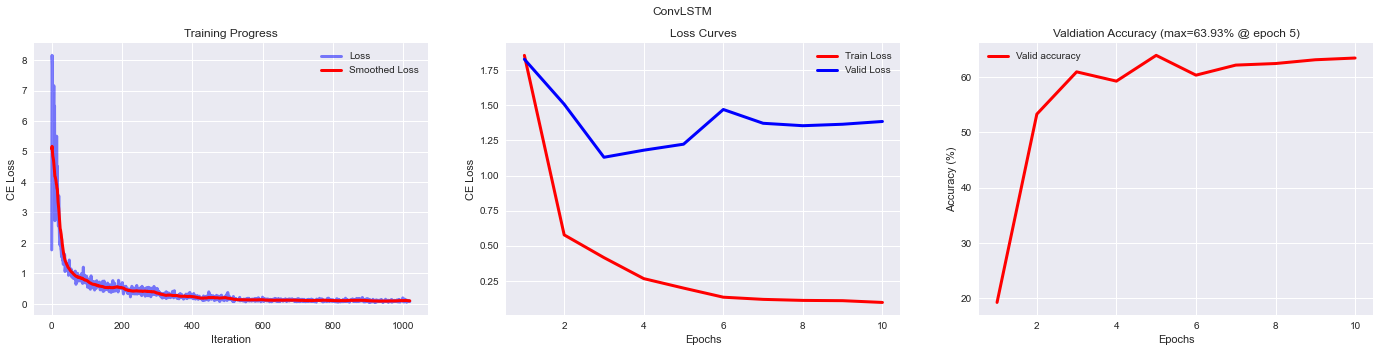

In [19]:
plot_analysis(loss_iters_conv_lstm, train_loss_conv_lstm, val_loss_conv_lstm, valid_acc_conv_lstm, "ConvLSTM")

Performance of ConvLSTM (own implementation) is very similar to the performance of the network with convolutional encoder and LSTMCell -module

#### **Extra Point**
  - Implement a 3D-CNN for action classification on the KTH-Actions dataset
  - Compare it with the RNN-based models

In [28]:
class CNN_3D(nn.Module):
    def __init__(self, n_actions=6):
        super().__init__()
        self.conv1 = self._conv_block(1, 16, k_size=(3, 3, 3), pool=True)
        self.conv2 = self._conv_block(16, 32, k_size=(3, 3, 3), pool=True)
        self.fc1 = nn.Linear(18816, 128)
        self.fc2 = nn.Linear(128, n_actions)
        self.activation = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.15) 
        
    def _conv_block(self, in_ch, out_ch, k_size=(3, 3, 3), pool=True):
        module = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, k_size, padding=0),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(),
        )
        if pool:
            module.add_module("Pool", nn.MaxPool3d(kernel_size=(2, 2, 2)))
        return module
    
    def forward(self, x):
        x = x.permute((0, 2, 1, 3, 4)).contiguous()
        y = self.conv1(x)
        y = self.conv2(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        y = self.activation(y)
        y = self.batchnorm(y)
        y = self.fc2(y)
        
        return y

In [29]:
cnn3d = CNN_3D()
cnn3d = cnn3d.to(device)

# classification loss function
criterion_cnn3d = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_cnn3d = torch.optim.Adam(cnn3d.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler_cnn3d = torch.optim.lr_scheduler.StepLR(optimizer_cnn3d, step_size=5, gamma=0.2)

train_loss_cnn3d, val_loss_cnn3d, loss_iters_cnn3d, valid_acc_cnn3d = train_model(
        model=cnn3d, optimizer=optimizer_cnn3d, scheduler=scheduler_cnn3d, criterion=criterion_cnn3d,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10
    )

Epoch 1 Iter 102: loss 0.45103. : 100%|██████████| 102/102 [00:45<00:00,  2.24it/s]


Epoch 1/10
    Train loss: 0.80091
    Valid loss: 3.63164
    Accuracy: 18.205055381993752%




Epoch 2 Iter 102: loss 0.39413. : 100%|██████████| 102/102 [00:45<00:00,  2.26it/s]


Epoch 2/10
    Train loss: 0.39572
    Valid loss: 0.832
    Accuracy: 69.78131212723659%




Epoch 3 Iter 102: loss 0.27819. : 100%|██████████| 102/102 [00:45<00:00,  2.26it/s]


Epoch 3/10
    Train loss: 0.26477
    Valid loss: 0.85719
    Accuracy: 65.60636182902584%




Epoch 4 Iter 102: loss 0.13908. : 100%|██████████| 102/102 [00:45<00:00,  2.26it/s]


Epoch 4/10
    Train loss: 0.18383
    Valid loss: 0.8527
    Accuracy: 70.00852030673104%




Epoch 5 Iter 102: loss 0.12079. : 100%|██████████| 102/102 [00:45<00:00,  2.26it/s]


Epoch 5/10
    Train loss: 0.15444
    Valid loss: 0.96471
    Accuracy: 63.27747798920761%




Epoch 6 Iter 102: loss 0.08894. : 100%|██████████| 102/102 [00:45<00:00,  2.26it/s]


Epoch 6/10
    Train loss: 0.09636
    Valid loss: 0.84326
    Accuracy: 70.83214995739847%




Epoch 7 Iter 102: loss 0.06271. : 100%|██████████| 102/102 [00:45<00:00,  2.26it/s]


Epoch 7/10
    Train loss: 0.07687
    Valid loss: 0.76396
    Accuracy: 72.47940925873331%




Epoch 8 Iter 102: loss 0.04499. : 100%|██████████| 102/102 [00:45<00:00,  2.26it/s]


Epoch 8/10
    Train loss: 0.06659
    Valid loss: 0.81531
    Accuracy: 71.37176938369781%




Epoch 9 Iter 102: loss 0.06171. : 100%|██████████| 102/102 [00:45<00:00,  2.23it/s]


Epoch 9/10
    Train loss: 0.0587
    Valid loss: 0.81542
    Accuracy: 71.96819085487077%




Epoch 10 Iter 102: loss 0.05292. : 100%|██████████| 102/102 [00:45<00:00,  2.23it/s]

Epoch 10/10
    Train loss: 0.05294
    Valid loss: 0.85276
    Accuracy: 71.7409826753763%


Training completed


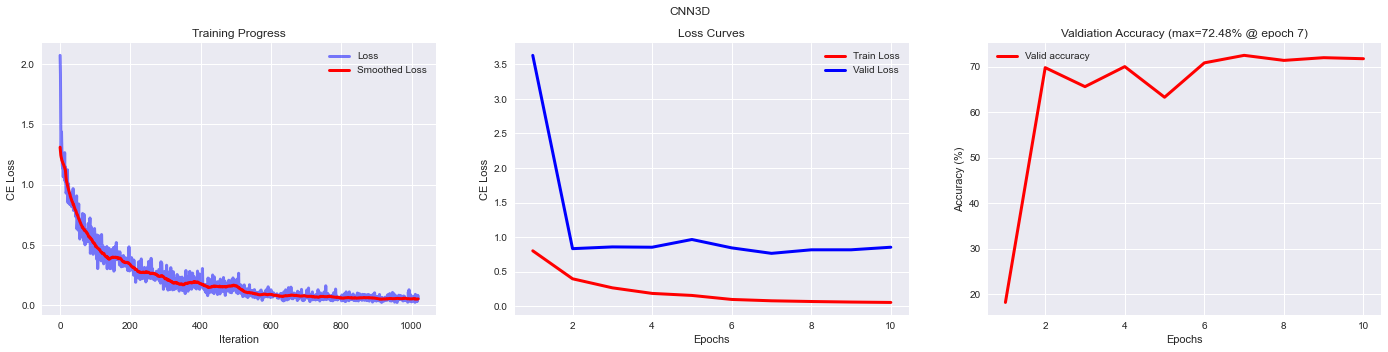

In [30]:
plot_analysis(loss_iters_cnn3d, train_loss_cnn3d, val_loss_cnn3d, valid_acc_cnn3d, "CNN3D")

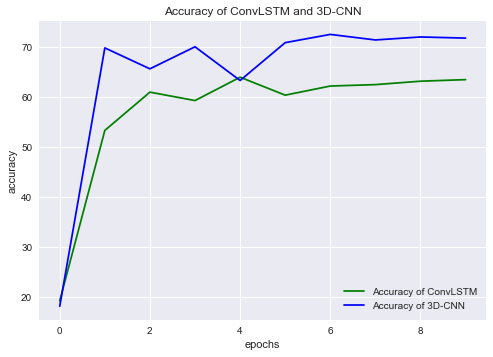

In [39]:
plt.plot(range(10), valid_acc_conv_lstm, label="Accuracy of ConvLSTM", color='green')
plt.plot(range(10), valid_acc_cnn3d, label="Accuracy of 3D-CNN", color='blue')

plt.title('Accuracy of ConvLSTM and 3D-CNN')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

Simple 3D-CNN model performs much better than any RNN model